In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
from astropy.cosmology import Planck15 as cosmo
from IPython import display

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import pk_tools as pk
import fg_tools as fg
import obs_tools as obs
import load_datacube as load

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

## Power spectrum bias correction

Here we will look at the Mertens et al. 2020 (M20; https://arxiv.org/pdf/2002.07196.pdf) method of unbiasing the recovered power spectrum of the GPR residual (the signal left after performning foreground removal).

M20 use a Monte Carlo procedure to do this correction (this is the __analytic FG error__):
1. First, draw a lot of random realisation of the data described by the foreground covariance (`fg_cov`)
2. Measure the power spectrum of each of these realisations
3. Average these power spectra
4. Add the averaged power spectrum to the residual power spectrum

The catch to this particular correction is that it assumes we know our 21cm covariance, i.e. the estimated 21cm covariance found by GPR is the real one. If this is not the case, it can lead to an overprediction or underprediction of the 21cm power spectrum, depending on whether the 21cm covariance is overpredicted or underpredicted.

This analytic correction should be equivalent to subtracting the foreground prediction from the true foreground signal (this is the __actual FG error__).

_The analytic and actual FG errors should be very similar._

Mertens demonstrates both of these bias corrections (analysic and actual) in this notebook: https://gitlab.com/flomertens/ps_eor/-/blob/master/doc/GPR%20theory%20and%20practice.ipynb

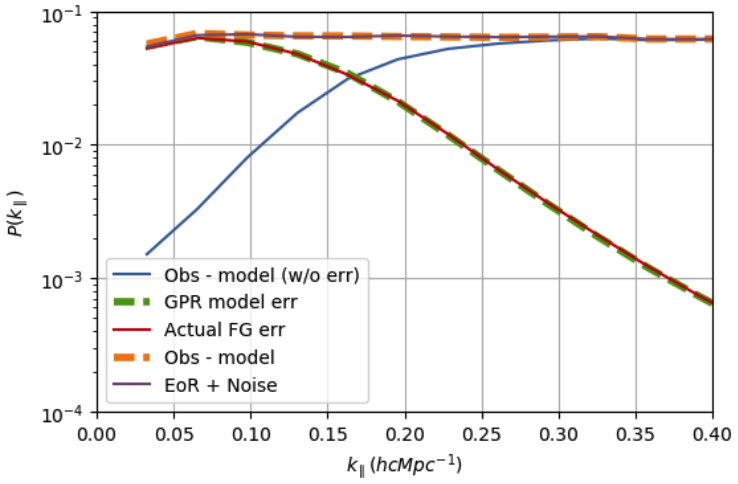

In [3]:
display.Image("../images/Mertens_bias_correction.png")

## Loading data

In [4]:
FGnopol_data = (np.load('../Data/dT_sync_Stripe82_noBeam.npy')
                + np.load('../Data/dT_free_Stripe82_noBeam.npy')
                + np.load('../Data/dT_psource_Stripe82_noBeam.npy'))
HI_data = np.load('../Data/T_HI-MDSAGE_z_0.39.npy')
HI_data = np.swapaxes(HI_data, 1, 2)
noise_data = np.load('../Data/dT_noise.npy')

Smoothing maps by constant telescope beam:

In [5]:
# smoothing maps
lx,ly,lz = 1000, 1000, 924.78 #Mpc/h
zmax = 0.58
sigma_beam = 1.55
FGnopol_HI_noise_smoothed = obs.ConvolveCube(FGnopol_data+HI_data+noise_data,zmax,lx,ly,sigma_beam, cosmo)
HI_noise_smoothed = obs.ConvolveCube(HI_data+noise_data,zmax,lx,ly,sigma_beam, cosmo)
noise_smoothed = obs.ConvolveCube(noise_data,zmax,lx,ly,sigma_beam, cosmo)
FGnopol_data_smoothed = obs.ConvolveCube(FGnopol_data,zmax,lx,ly,sigma_beam, cosmo)

Calculate PCA residual in order to compare with GPR residual:

In [6]:
pca_res_nopol3 = fg.PCAclean(FGnopol_HI_noise_smoothed, N_FG=3)[0]
pca_res_nopol2 = fg.PCAclean(FGnopol_HI_noise_smoothed, N_FG=2)[0]

## Running GPR

Defining input data and frequency range:

In [7]:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
freqs = np.arange(vmin, vmax, df)
Input = FGnopol_HI_noise_smoothed

Choosing kernels for the different signals (RBF for smooth foregrounds, Exponential for 21cm and noise combined):

In [14]:
kern_fg = GPy.kern.RBF(1)

kern_21 = GPy.kern.Exponential(1)
kern_21.lengthscale.constrain_bounded(0.0,15.0)

reconstraining parameters Exponential.lengthscale


Running GPR, to obtain:
- `gpr_res`: the residual goreground removed data
- `fg_cov`: the foreground covariance (error in the foreground fit), used for the bias correction
- `model`: the optimised GPR model
- `fg_fit`: the foreground fit, which is removed from the data to yield the residual `gpr_res`

In [16]:
gpr_res, fg_cov, model = fg.GPRclean(Input, freqs, kern_fg, kern_21, NprePCA=0, num_restarts=40, 
                                      noise_data=None, heteroscedastic=False, zero_noise=True, invert=True)
# this extracts the foreground fit:
fg_fit, fg_cov = model.predict(freqs[:, np.newaxis], full_cov=True, kern=model.kern.rbf,
        include_likelihood=False)

Optimization restart 1/40, f = -46577051.5735673
Optimization restart 2/40, f = 64449329.769392945
Optimization restart 3/40, f = 64449329.68009665
Optimization restart 4/40, f = 64449329.753516644
Optimization restart 5/40, f = 64449329.68009773
Optimization restart 6/40, f = 64449329.68012447
Optimization restart 7/40, f = 64449329.70969587
Optimization restart 8/40, f = 64449329.68026507
Optimization restart 9/40, f = 64449329.79068695
Optimization restart 10/40, f = 64449329.811470985
Optimization restart 11/40, f = -46577052.09489219
Optimization restart 12/40, f = -46577052.22403725
Optimization restart 13/40, f = 64449329.68038075
Optimization restart 14/40, f = 64449329.73291591
Optimization restart 15/40, f = -46554238.34739667
Optimization restart 16/40, f = 64449329.81539856
Optimization restart 17/40, f = 64449329.68265681
Optimization restart 18/40, f = 64449329.685192704
Optimization restart 19/40, f = -46577051.77216643
Optimization restart 20/40, f = -46407465.35625242


In [17]:
model

GP_regression.,value,constraints,priors
sum.rbf.variance,162656.94201806645,+ve,
sum.rbf.lengthscale,494.6041754500677,+ve,
sum.Exponential.variance,0.0010800136149365718,+ve,
sum.Exponential.lengthscale,5.938601227149504,"0.0,15.0",
Gaussian_noise.variance,0.0,+ve fixed,


Let's take a look at the foreground covariance and what it looks like:

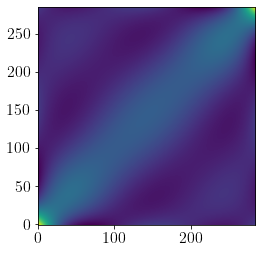

In [18]:
plt.imshow(fg_cov, origin='lower')

Let's also look at what the foreground residuals (`fg_res`) look like. These are the foreground data minus the foreground fit (`fg_fit`). It looks similar but not exactly the same as above - there are some off diagonal components that we don't see in the foreground covariance.

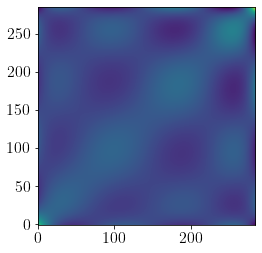

In [19]:
FGnopol_data_smoothed_los = load.LoSpixels(FGnopol_data_smoothed)
FGnopol_data_smoothed_los = FGnopol_data_smoothed_los[::-1]
fg_res = FGnopol_data_smoothed_los-fg_fit
fg_cov_actual = np.cov(fg_res)

plt.imshow(fg_cov_actual, origin='lower')

## Analytic bias correction

1. Drawing a lot of random realisation of the data described by the foreground covariance `fg_cov`

In [20]:
n_pix, n_freqs = Input.shape[0]*Input.shape[1], Input.shape[2]

mu = np.zeros(n_freqs)# vector of the means, zero
n_samples = 10

# Generate n separate samples paths from a Gaussian with mean mu and covariance fg_cov:
samples = []
for i in range(n_samples):
    s = np.random.multivariate_normal(mu, fg_cov, (Input.shape[0]*Input.shape[1]))# * Input.std() * noise_smoothed.std()
    s = s[::-1]
    s = np.reshape(s,(Input.shape[0], Input.shape[1], Input.shape[2]))
    samples.append(s)

samples = np.array(samples)

Let's compare these samples to the actual foreground residuals. They look similar in the LoS direction.

Text(0, 0.5, 'Temperature (mK)')

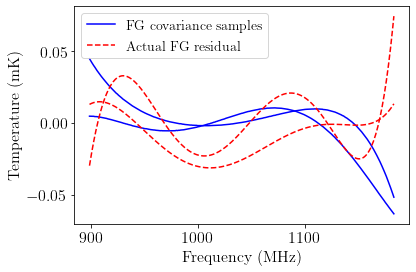

In [21]:
plt.plot(freqs, load.LoSpixels(samples[1])[:,10], c='b', label='FG covariance samples')
plt.plot(freqs, load.LoSpixels(samples[1])[:,200], c='b')
plt.plot(freqs, fg_res[:,10], ls='dashed', c='r', label='Actual FG residual')
plt.plot(freqs, fg_res[:,200], ls='dashed', c='r')

plt.legend(fontsize=14)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (mK)')

Let's also compare the actual foreground residual data cube, to one of the FG covariance samples datacube. Since we've already compared the LoS component, we can now compare redshift slices. As seen below, __they do not look similar__. This is because when we generate the FG covariance samples, we only have the frequency covariance information, we have no spatial information in the transverse to the LoS direction, so the redshift slices are essentially random noise. 

The foreground residual on the other hand, has the transverse to the LoS information since we get it directly from the data.

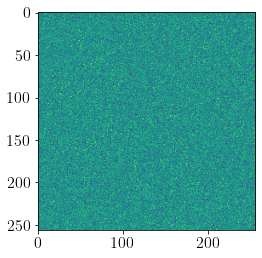

In [22]:
plt.imshow(samples[0][:,:,10])

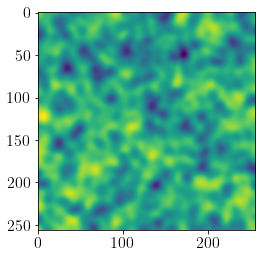

In [23]:
fg_res = np.swapaxes(fg_res,0,1)
fg_res = np.reshape(fg_res,(Input.shape[0], Input.shape[1], Input.shape[2]))

plt.imshow(fg_res[:,:,10])

To demonstrate this difference further, let's create a random sample using the covariance of the actual foreground residuals. We see that we get again only random noise in the transverse direction.

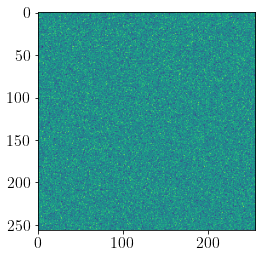

In [24]:
sample_fg_res = np.random.multivariate_normal(mu, fg_cov_actual, (Input.shape[0], Input.shape[1]))

plt.imshow(sample_fg_res[:,:,10])

2. Measure the power spectrum of each of these realisations

In [25]:
# Dimension of data cube:
nx,ny,nz = 256, 256, 285
# Measure the auto-power spectrum, with noise:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 1
dk = 2*kmin
nkbin = int((kmax-kmin)/dk)
kbins = np.arange(kmin,kmax,dk)
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
# weighting and window function:
w = W = np.ones((nx,ny,nz))

In [26]:
samples_pk = []

for s in samples:
    samples_pk.append(pk.getpk(s,w,W,nx,ny,nz,lx,ly,lz,kbins)[0])
    
samples_pk = np.array(samples_pk)

Let's also for fun calculate the power spectrum of the sample generated from the actual foreground error covariance (`sample_fg_res`).

In [67]:
sample_fg_res_pk = pk.getpk(sample_fg_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

3. Average these power spectra

In [27]:
samples_pk_avg = np.mean(samples_pk, axis=0)

4. Add the averaged power spectrum to the residual power spectrum

In [28]:
# residual power spectrum:
res_pk = pk.getpk(gpr_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# applying analytic bias correction:
res_pk_corr = res_pk + samples_pk_avg

# foreground residual power spectrum:
fg_res_pk = pk.getpk(fg_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# applying actual bias correction:
res_pk_truecorr = res_pk + fg_res_pk

# true residual power spectrum:
HI_pk = pk.getpk(HI_noise_smoothed,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

Text(0.5, 0, 'k [$h$/Mpc]')

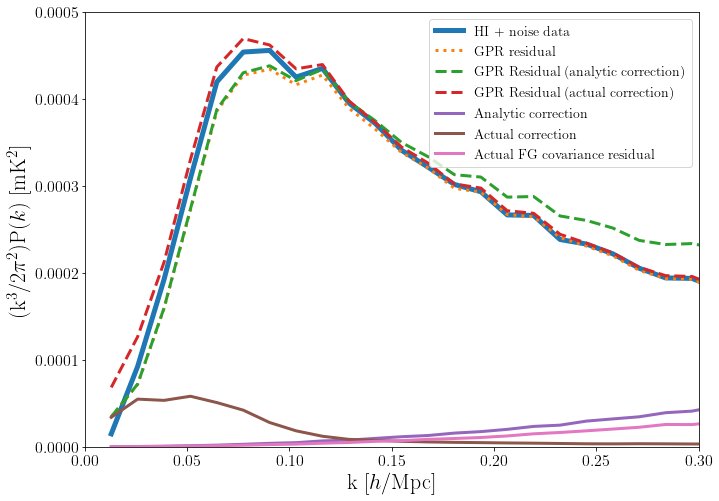

In [69]:
plt.figure(figsize=(11,8))
plt.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi),ls='solid', lw=5, label = r'HI + noise data')
plt.plot(k, (k*k*k*res_pk)/(2*np.pi*np.pi),ls='dotted', lw=3, label = r'GPR residual')
plt.plot(k, (k*k*k*res_pk_corr)/(2*np.pi*np.pi),ls='dashed', lw=3, label = r'GPR Residual (analytic correction)')
plt.plot(k, (k*k*k*res_pk_truecorr)/(2*np.pi*np.pi),ls='dashed', lw=3, label = r'GPR Residual (actual correction)')
plt.plot(k, (k*k*k*samples_pk_avg)/(2*np.pi*np.pi), lw=3, label = r'Analytic correction')
plt.plot(k, (k*k*k*fg_res_pk)/(2*np.pi*np.pi), lw=3, label = r'Actual correction')
plt.plot(k, (k*k*k*sample_fg_res_pk)/(2*np.pi*np.pi), lw=3, label = r'Actual FG covariance residual')

plt.legend(fontsize=14)
plt.xlim(0,0.3)
plt.ylim(0,0.0005)
plt.ylabel('(k$^3$/2$\pi^2$)P($k$) [mK$^2$]', fontsize=22)
plt.xlabel('k [$h$/Mpc]', fontsize=22)

Looking now at the 1D power spectrum in the LoS direction (code adapted from `Pylians` https://github.com/liambx/Pylians/blob/master/Pk/1D/Pk_1D.py):

In [30]:
import scipy.fftpack

def Pk_para(delta, nx, ny, nz, lx, ly, lz):

    axis = 2
    axis1 = {0:1, 1:0, 2:0} #after stack along one axis delta_k has 2 dimensions
    axis2 = {0:1, 1:1, 2:0}  
    
    delta_k = scipy.fftpack.ifftn(delta,overwrite_x=True,axes=(axis,))

    # compute the value of |delta(k)|^2
    delta_k2 = np.absolute(delta_k)**2

    # take all LOS and compute the average value for each mode
    delta_k2 = np.mean(delta_k2,dtype=np.float64,axis=axis1[axis])
    delta_k2 = np.mean(delta_k2,dtype=np.float64,axis=axis2[axis])
    
    # compute the values of k for the 1D P(k)
    dims = nz
    BoxSize = lz
    k = np.arange(dims,dtype=np.float64)
    middle = int(dims/2)

    indexes = np.where(k>middle)[0]
    k[indexes] = k[indexes] - dims

    k *= (2.0*np.pi/BoxSize)  #k in h/Mpc
    k = np.absolute(k)  #just take the modulus of the wavenumber

    # define the k-bins
    k_bins = np.linspace(0,int(dims/2),int(dims/2)+1)*(2.0*np.pi/BoxSize)

    # compute the number of modes and the averange number-weighted value of k 
    modes = np.histogram(k,bins=k_bins)[0]
    #print(modes)
    k_bin = np.histogram(k,bins=k_bins,weights=k)[0]/modes

    # compute the 1D P(k) and save results ignoring the DC mode
    Pk = np.histogram(k,bins=k_bins,weights=delta_k2)[0]
    Pk = Pk*BoxSize/modes  #Mpc/h
    
    # compute 3D P(k):
    k_3D  = 0.5*(k_bin[1:]+k_bin[:-1])
    Pk_3D = -2.0*np.pi/k_3D*(Pk[1:]-Pk[:-1])/(k_bin[1:]-k_bin[:-1])
    return k_bin, Pk, k_3D, Pk_3D

In [73]:
k1d, pk1d, k3d, pk3d = Pk_para(HI_noise_smoothed, nx, ny, nz, lx, ly, lz)
k1d, pk1dsamp, k3d, pk3d = Pk_para(samples[0], nx, ny, nz, lx, ly, lz)
k1d, pk1dsub, k3d, pk3d = Pk_para(fg_res, nx, ny, nz, lx, ly, lz)
k1d, pk1dres, k3d, pk3d = Pk_para(gpr_res, nx, ny, nz, lx, ly, lz)
k1d, pk1dresPCA3, k3d, pk3d = Pk_para(pca_res_nopol3, nx, ny, nz, lx, ly, lz)
k1d, pk1dresPCA2, k3d, pk3d = Pk_para(pca_res_nopol2, nx, ny, nz, lx, ly, lz)

It seems from below that the Analytic and Actual corrections are similar in the LoS direction, but more importantly it seems like FG removal isn't playing a huge role in biasing the power spectrum in the LoS direction, _as is usually assumed_. Because GPR as a foreground removal method uses mainly LoS direction information, it could be that GPR is actually really good at removing foregrounds in the LoS direction, but not in the perpendicular to the LoS direction... I'm not sure about this yet, need to think about it a bit more!

Would be interesting to also look at P($k_\perp$) and see if we're losing more signal there...

Text(0, 0.5, '$k$P($k_\\parallel$) [mK$^2$]')

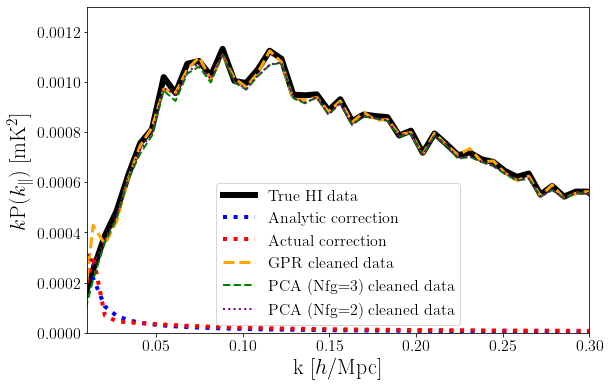

In [78]:
plt.figure(figsize=(9,6))

plt.plot(k1d, k1d*pk1d, ls='solid', lw=6, c='k', label='True HI data')
plt.plot(k1d, k1d*pk1dsamp, lw=4, ls='dotted', c='b', label="Analytic correction")
plt.plot(k1d, k1d*pk1dsub, lw=4, ls='dotted', c='r', label='Actual correction')
plt.plot(k1d, k1d*pk1dres, lw=3, ls='dashed', c='orange', label='GPR cleaned data')
plt.plot(k1d, k1d*pk1dresPCA3, lw=2, ls='dashed', c='green', label='PCA (Nfg=3) cleaned data')
plt.plot(k1d, k1d*pk1dresPCA2, lw=2, ls='dotted', c='purple', label='PCA (Nfg=2) cleaned data')

plt.legend()

plt.ylim(0, 0.0013)
plt.xlim(3*np.pi/lz, 0.3)
plt.xlabel('k [$h$/Mpc]', fontsize=22)
plt.ylabel('$k$P($k_\parallel$) [mK$^2$]', fontsize=22)

Text(0, 0.5, '$k$P($k_\\parallel$) [mK$^2$]')

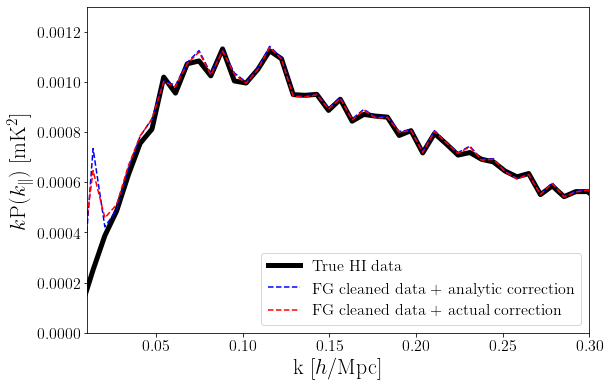

In [59]:
plt.figure(figsize=(9,6))

plt.plot(k1d, k1d*pk1d, ls='solid', lw=5, c='k', label='True HI data')
plt.plot(k1d, k1d*(pk1dres+pk1dsub), ls='dashed', c='b', label='FG cleaned data + analytic correction')
plt.plot(k1d, k1d*(pk1dres+pk1dsamp), ls='dashed', c='r', label='FG cleaned data + actual correction')

plt.legend()
plt.ylim(0, 0.0013)
plt.xlim(3*np.pi/lz, 0.3)
plt.xlabel('k [$h$/Mpc]', fontsize=22)
plt.ylabel('$k$P($k_\parallel$) [mK$^2$]', fontsize=22)

Let's also look at the 2D power spectrum:

In [64]:
k_min_perp = 2*np.pi/(np.sqrt(2)*nx)
k_min_par = 2*np.pi/nz
dpar = 12
dperp = 10

In [65]:
kpar=np.linspace(k_min_par,0.6,dpar+1)
kperp=np.linspace(np.sqrt(2)*kmin2,0.4,dperp+1)
pk2d,nmodes = pk.PerpParaPk(HI_noise_smoothed,nx,ny,nz,lx,ly,lz,kperp,kpar,w,W)
pk2dFG,nmodes = pk.PerpParaPk(gpr_res,nx,ny,nz,lx,ly,lz,kperp,kpar,w,W)
pk2dFGpca3,nmodes = pk.PerpParaPk(pca_res_nopol3,nx,ny,nz,lx,ly,lz,kperp,kpar,w,W)
pk2dFGpca2,nmodes = pk.PerpParaPk(pca_res_nopol2,nx,ny,nz,lx,ly,lz,kperp,kpar,w,W)


Calculating P(k_perp,k_para)...

Calculating P(k_perp,k_para)...

Calculating P(k_perp,k_para)...

Calculating P(k_perp,k_para)...


Text(0.5, 1.0, 'PCA (Nfg = 2) cleaned/True HI')

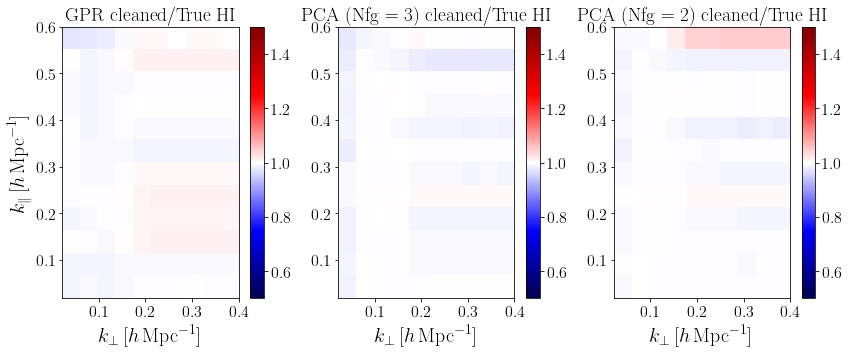

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), ncols=3)

histmap1 = np.zeros((dpar,dperp))
histmap2 = np.zeros((dpar,dperp))
histmap3 = np.zeros((dpar,dperp))
for i in range(dpar):
        for j in range(dperp):
            histmap1[i,j] = pk2dFG[i,j]/pk2d[i,j]
            histmap2[i,j] = pk2dFGpca3[i,j]/pk2d[i,j]
            histmap3[i,j] = pk2dFGpca2[i,j]/pk2d[i,j]

pos1 = ax1.imshow(histmap1, extent=[k_min_par,0.4,k_min_perp,0.6], cmap='seismic', vmin=0.5, vmax=1.5)
fig.colorbar(pos1, ax=ax1)
ax1.set_xlabel(r'$k_\perp \, [h \, {\rm Mpc}^{-1}]$',fontsize=20)
ax1.set_ylabel(r'$k_\parallel \, [h \, {\rm Mpc}^{-1}]$',fontsize=20)
ax1.set_xticks([0.1,0.2,0.3,0.4])
ax1.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax1.set_title('GPR cleaned/True HI')

pos2 = ax2.imshow(histmap2, extent=[k_min_par,0.4,k_min_perp,0.6], cmap='seismic', vmin=0.5, vmax=1.5)
fig.colorbar(pos2, ax=ax2)
ax2.set_xlabel(r'$k_\perp \, [h \, {\rm Mpc}^{-1}]$',fontsize=20)
ax2.set_xticks([0.1,0.2,0.3,0.4])
ax2.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax2.set_title('PCA (Nfg = 3) cleaned/True HI')

pos3 = ax3.imshow(histmap3, extent=[k_min_par,0.4,k_min_perp,0.6], cmap='seismic', vmin=0.5, vmax=1.5)
fig.colorbar(pos3, ax=ax3)
ax3.set_xlabel(r'$k_\perp \, [h \, {\rm Mpc}^{-1}]$',fontsize=20)
ax3.set_xticks([0.1,0.2,0.3,0.4])
ax3.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax3.set_title('PCA (Nfg = 2) cleaned/True HI')